In [1]:
import pandas as pd
import numpy as np

from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.linear_model import LogisticRegression

from catboost import CatBoostClassifier
from lightgbm.sklearn import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [2]:
import nltk
nltk.download('vader_lexicon', quiet=True)
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Initial dataset import and processing

In [3]:
pd.options.display.max_colwidth = 500
pd.options.display.max_columns = 30

In [4]:
brand_df = pd.read_csv('twitter_data_processed.csv')
brand_df = brand_df.reset_index(drop = True)

In [5]:
brand_df.shape

(2308, 31)

In [6]:
brand_df.head(2)

,handle,twitter_name,is_other_user_rt,is_reply,text,num_hearts,num_retweets,tweet_length,time_tweeted,tweet_age_days,hashtags,num_hashtags,num_mentions,retweeted_by_user,emojis,...,media,media_url,media_link,tweet_text_only,grammar_errors_per_word,num_words,entities,reply_to_user_id,tweet_id,source,handle_avg_hearts,handle_avg_rts,prptn_rts_vs_acc_avg,prptn_hrts_vs_acc_avg,joke_or_meme
0,HomeDepot,The Home Depot,False,False,Spoil the coffee lover in your life with the gift of a better brew. Shop coffee makers and cappuccino machines today. https://t.co/JIhbKm73j9 https://t.co/salrrrN0fs,20,3,165,2020-11-22 15:00:01,31,NaN,0,0,False,NaN,...,photo,https://pbs.twimg.com/media/Enb6wj1WEAsj---.jpg,https://t.co/salrrrN0fs,Spoil the coffee lover in your life with the gift of a better brew. Shop coffee makers and cappuccino machines today.,0.000000,21,"{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [{'url': 'https://t.co/JIhbKm73j9', 'expanded_url': 'https://thd.co/3fmDeig', 'display_url': 'thd.co/3fmDeig', 'indices': [118, 141]}], 'media': [{'id': 1330526452094210059, 'id_str': '1330526452094210059', 'indices': [142, 165], 'media_url': 'http://pbs.twimg.com/media/Enb6wj1WEAsj---.jpg', 'media_url_https': 'https://pbs.twimg.com/media/Enb6wj1WEAsj---.jpg', 'url': 'https://t.co/salrrrN0fs', 'display_url': 'pic.twitter.com/salrrr...",NaN,1.330530e+18,Sprinklr Publishing,43.732283,10.440945,0.287330,0.457328,0.0
1,WestJet,WestJet,False,False,"As we continue to put your #SafetyAboveAll, we've adjusted our service on certain flights. To discover what service offerings will be available on your upcoming flight, visit https://t.co/SQdQK2XwWX https://t.co/1xvZDsjA3b",29,10,222,2020-11-18 14:04:01,35,SafetyAboveAll,1,0,False,NaN,...,photo,https://pbs.twimg.com/media/EnHHlUQW8AMo7xl.jpg,https://t.co/1xvZDsjA3b,"As we continue to put your , we've adjusted our service on certain flights. To discover what service offerings will be available on your upcoming flight, visit",0.074074,27,"{'hashtags': [{'text': 'SafetyAboveAll', 'indices': [27, 42]}], 'symbols': [], 'user_mentions': [], 'urls': [{'url': 'https://t.co/SQdQK2XwWX', 'expanded_url': 'https://ms.spr.ly/6016pG1TM', 'display_url': 'ms.spr.ly/6016pG1TM', 'indices': [175, 198]}], 'media': [{'id': 1329062808957415427, 'id_str': '1329062808957415427', 'indices': [199, 222], 'media_url': 'http://pbs.twimg.com/media/EnHHlUQW8AMo7xl.jpg', 'media_url_https': 'https://pbs.twimg.com/media/EnHHlUQW8AMo7xl.jpg', 'url': 'https:/...",NaN,1.329060e+18,Sprinklr Publishing,83.434426,17.500000,0.571429,0.347578,0.0


In [7]:
brand_df['tweet_text_only'] = brand_df['tweet_text_only'].str.replace('&amp;','&')
brand_df = brand_df.loc[brand_df['num_hearts'] != 0]
brand_df = brand_df.drop(columns=['handle_avg_hearts', 'handle_avg_rts', 'prptn_rts_vs_acc_avg', 'prptn_hrts_vs_acc_avg'])

avg_likes = brand_df.groupby('handle', as_index=False)['num_hearts'].mean()
avg_likes.columns = ['handle', 'handle_avg_hearts']
avg_retweets = brand_df.groupby('handle', as_index=False)['num_retweets'].mean()
avg_retweets.columns = ['handle', 'handle_avg_rts']
brand_df = brand_df.merge(avg_likes, on='handle', how='left')
brand_df = brand_df.merge(avg_retweets, on='handle', how='left')
brand_df['prptn_rts_vs_acc_avg'] = brand_df['num_retweets']/brand_df['handle_avg_rts']
brand_df['prptn_hrts_vs_acc_avg'] = brand_df['num_hearts']/brand_df['handle_avg_hearts']

In [8]:
mod = SentimentIntensityAnalyzer()
for i in range(len(brand_df)-1):
    brand_df.at[i, 'sentiment_polarity'] = mod.polarity_scores(str(brand_df['tweet_text_only'][i]))['compound']

In [9]:
brand_df.shape

(1993, 32)

In [10]:
brand_df_classified = brand_df[brand_df['joke_or_meme'].notna()]

In [11]:
brand_df_classified.shape

(469, 32)

In [12]:
brand_df_classified.head(2)

,handle,twitter_name,is_other_user_rt,is_reply,text,num_hearts,num_retweets,tweet_length,time_tweeted,tweet_age_days,hashtags,num_hashtags,num_mentions,retweeted_by_user,emojis,...,media_url,media_link,tweet_text_only,grammar_errors_per_word,num_words,entities,reply_to_user_id,tweet_id,source,joke_or_meme,handle_avg_hearts,handle_avg_rts,prptn_rts_vs_acc_avg,prptn_hrts_vs_acc_avg,sentiment_polarity
0,HomeDepot,The Home Depot,False,False,Spoil the coffee lover in your life with the gift of a better brew. Shop coffee makers and cappuccino machines today. https://t.co/JIhbKm73j9 https://t.co/salrrrN0fs,20,3,165,2020-11-22 15:00:01,31,NaN,0,0,False,NaN,...,https://pbs.twimg.com/media/Enb6wj1WEAsj---.jpg,https://t.co/salrrrN0fs,Spoil the coffee lover in your life with the gift of a better brew. Shop coffee makers and cappuccino machines today.,0.000000,21,"{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [{'url': 'https://t.co/JIhbKm73j9', 'expanded_url': 'https://thd.co/3fmDeig', 'display_url': 'thd.co/3fmDeig', 'indices': [118, 141]}], 'media': [{'id': 1330526452094210059, 'id_str': '1330526452094210059', 'indices': [142, 165], 'media_url': 'http://pbs.twimg.com/media/Enb6wj1WEAsj---.jpg', 'media_url_https': 'https://pbs.twimg.com/media/Enb6wj1WEAsj---.jpg', 'url': 'https://t.co/salrrrN0fs', 'display_url': 'pic.twitter.com/salrrr...",NaN,1.330530e+18,Sprinklr Publishing,0.0,48.518987,10.518987,0.285199,0.412210,0.8625
1,WestJet,WestJet,False,False,"As we continue to put your #SafetyAboveAll, we've adjusted our service on certain flights. To discover what service offerings will be available on your upcoming flight, visit https://t.co/SQdQK2XwWX https://t.co/1xvZDsjA3b",29,10,222,2020-11-18 14:04:01,35,SafetyAboveAll,1,0,False,NaN,...,https://pbs.twimg.com/media/EnHHlUQW8AMo7xl.jpg,https://t.co/1xvZDsjA3b,"As we continue to put your , we've adjusted our service on certain flights. To discover what service offerings will be available on your upcoming flight, visit",0.074074,27,"{'hashtags': [{'text': 'SafetyAboveAll', 'indices': [27, 42]}], 'symbols': [], 'user_mentions': [], 'urls': [{'url': 'https://t.co/SQdQK2XwWX', 'expanded_url': 'https://ms.spr.ly/6016pG1TM', 'display_url': 'ms.spr.ly/6016pG1TM', 'indices': [175, 198]}], 'media': [{'id': 1329062808957415427, 'id_str': '1329062808957415427', 'indices': [199, 222], 'media_url': 'http://pbs.twimg.com/media/EnHHlUQW8AMo7xl.jpg', 'media_url_https': 'https://pbs.twimg.com/media/EnHHlUQW8AMo7xl.jpg', 'url': 'https:/...",NaN,1.329060e+18,Sprinklr Publishing,0.0,72.147541,11.524590,0.867710,0.401954,0.2732


# Data splitting and category classification

In [13]:
brand_df_drops = brand_df_classified.drop(columns = ['twitter_name','text','num_hearts',
                                                     'num_retweets', 'time_tweeted',
                                                     'tweet_age_days', 'hashtags', 'retweeted_by_user',
                                                     'media_url', 'media_link', 'entities', 'reply_to_user_id',
                                                     'tweet_id', 'handle_avg_hearts', 'handle_avg_rts',
                                                     'num_words', 'is_other_user_rt', 'is_reply', 'handle',
                                                     'emojis'])

In [14]:
brand_df_drops['joke_or_meme'] = brand_df_drops['joke_or_meme'].astype(bool)
brand_df_drops['media'] = brand_df_drops['media'].replace('photo', 'True')
brand_df_drops = brand_df_drops.where(pd.notnull(brand_df_drops), 0)
brand_df_drops['media'] = brand_df_drops['media'].astype(bool)

brand_df_drops['tweet_text_only'] = brand_df_drops['tweet_text_only'].astype('str')
brand_df_drops['source'] = brand_df_drops['source'].astype('str')

In [15]:
brand_df_drops.shape

(469, 12)

In [16]:
# Checking for class imbalance
brand_df_drops['joke_or_meme'].value_counts(normalize=True) * 100

False    62.260128
True     37.739872
Name: joke_or_meme, dtype: float64

In [17]:
# for i in range(len(brand_df_drops)-1):
#     if brand_df_drops['emojis'][i] != '0':
#         brand_df_drops['emojis'][i] = brand_df_drops['emojis'][i].replace('',' ').strip()
#     else:
#         brand_df_drops['emojis'][i] = brand_df_drops['emojis'][i]

In [18]:
brand_df_drops.head(2)

,tweet_length,num_hashtags,num_mentions,num_emojis,media,tweet_text_only,grammar_errors_per_word,source,joke_or_meme,prptn_rts_vs_acc_avg,prptn_hrts_vs_acc_avg,sentiment_polarity
0,165,0,0,0,True,Spoil the coffee lover in your life with the gift of a better brew. Shop coffee makers and cappuccino machines today.,0.000000,Sprinklr Publishing,False,0.285199,0.412210,0.8625
1,222,1,0,0,True,"As we continue to put your , we've adjusted our service on certain flights. To discover what service offerings will be available on your upcoming flight, visit",0.074074,Sprinklr Publishing,False,0.867710,0.401954,0.2732


In [19]:
brand_df_drops.dtypes

tweet_length                 int64
num_hashtags                 int64
num_mentions                 int64
num_emojis                   int64
media                         bool
tweet_text_only             object
grammar_errors_per_word    float64
source                      object
joke_or_meme                  bool
prptn_rts_vs_acc_avg       float64
prptn_hrts_vs_acc_avg      float64
sentiment_polarity         float64
dtype: object

In [20]:
train_df, test_df = train_test_split(brand_df_drops, test_size=0.3, random_state=123)

Text(0.5, 1.0, 'Correlation Chart of All Features in train_df')

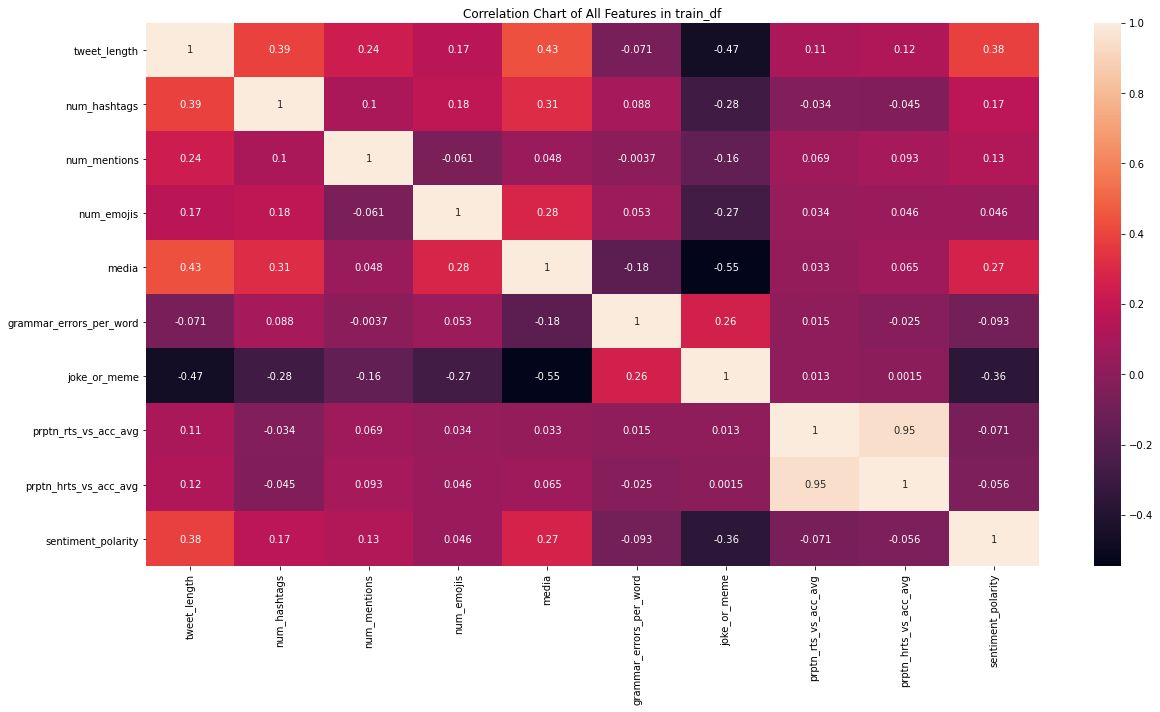

In [21]:
plt.figure(figsize=(20,10))
c= train_df.corr()
sns.heatmap(c,annot=True).set_title('Correlation Chart of All Features in train_df')

# Preprocessing

In [22]:
X_train, y_train = train_df.drop(columns=['joke_or_meme']), train_df['joke_or_meme']
X_test, y_test = test_df.drop(columns=['joke_or_meme']), test_df['joke_or_meme']

In [23]:
X_train.dtypes

tweet_length                 int64
num_hashtags                 int64
num_mentions                 int64
num_emojis                   int64
media                         bool
tweet_text_only             object
grammar_errors_per_word    float64
source                      object
prptn_rts_vs_acc_avg       float64
prptn_hrts_vs_acc_avg      float64
sentiment_polarity         float64
dtype: object

In [24]:
categorical_features = ["source"]
binary_features = ["media"]
text_feature = "tweet_text_only"

numeric_features = list(
    set(X_train.columns)
    - set(binary_features)
    - set(categorical_features)
    - set(text_feature)
)

numeric_features.remove('tweet_text_only')

preprocessor = make_column_transformer(
    (OneHotEncoder(handle_unknown="ignore"), categorical_features),
    (CountVectorizer(max_features=20000), text_feature),
    ("passthrough", binary_features),
    (StandardScaler(), numeric_features)
)

In [25]:
numeric_features

['num_hashtags',
 'prptn_rts_vs_acc_avg',
 'sentiment_polarity',
 'num_emojis',
 'num_mentions',
 'prptn_hrts_vs_acc_avg',
 'tweet_length',
 'grammar_errors_per_word']

# Testing Basic Pipelines

In [26]:
dummy_pipe = make_pipeline(preprocessor, DummyClassifier(strategy="stratified"))

pd.DataFrame(
    cross_validate(
        dummy_pipe,
        X_train,
        y_train,
        return_train_score=True
    )
).mean()

fit_time       0.016549
score_time     0.007462
test_score     0.521585
train_score    0.533538
dtype: float64

In [27]:
cv_baseline = make_pipeline(
    preprocessor, LogisticRegression(max_iter=1000, class_weight="balanced")
)

pd.DataFrame(
    cross_validate(
        cv_baseline,
        X_train,
        y_train,
        return_train_score=True,
        scoring=["f1", "accuracy"],
    )
).mean()

fit_time          0.032831
score_time        0.007774
test_f1           0.767958
train_f1          0.961613
test_accuracy     0.823077
train_accuracy    0.970278
dtype: float64

# Decision Tree

In [28]:
# code to store cross validation results

def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation
    """
    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

In [29]:
results = {}
dt_pipe = make_pipeline(preprocessor, DecisionTreeClassifier())

results["decisicion tree"] = mean_std_cross_val_scores(
    dt_pipe, X_train, y_train, return_train_score=True
)

pd.DataFrame(results)

,decisicion tree
fit_time,0.020 (+/- 0.002)
score_time,0.007 (+/- 0.001)
test_score,0.771 (+/- 0.058)
train_score,1.000 (+/- 0.000)


In [30]:
pipe_lr = make_pipeline(preprocessor, LogisticRegression(max_iter=2000, random_state=2))
pipe_rf = make_pipeline(preprocessor, RandomForestClassifier(random_state=2, class_weight="balanced"))
pipe_xgb = make_pipeline(preprocessor, XGBClassifier(random_state=2))
pipe_lgbm = make_pipeline(preprocessor, LGBMClassifier(random_state=2))
pipe_catboost = make_pipeline(
    preprocessor, CatBoostClassifier(verbose=0, random_state=123)
)

classifiers = {
    "logistic regression": pipe_lr,
    "balanced random forest": pipe_rf,
    "XGBoost": pipe_xgb,
    "LightGBM": pipe_lgbm,
}

In [31]:
for (name, model) in classifiers.items():
    results[name] = mean_std_cross_val_scores(
        model, X_train, y_train, return_train_score=True, scoring = "accuracy"
    )

pd.DataFrame(results)

/Users/mpin/opt/miniconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:50:59] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mpin/opt/miniconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:50:59] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mpin/opt/miniconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:50:59] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mpin/opt/miniconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/mpin/opt/miniconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:50:59] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:50:59] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,decisicion tree,logistic regression,balanced random forest,XGBoost,LightGBM
fit_time,0.020 (+/- 0.002),0.033 (+/- 0.002),0.157 (+/- 0.004),0.198 (+/- 0.043),0.051 (+/- 0.012)
score_time,0.007 (+/- 0.001),0.008 (+/- 0.000),0.016 (+/- 0.001),0.013 (+/- 0.001),0.009 (+/- 0.000)
test_score,0.771 (+/- 0.058),0.823 (+/- 0.024),0.841 (+/- 0.033),0.832 (+/- 0.046),0.820 (+/- 0.045)
train_score,1.000 (+/- 0.000),0.977 (+/- 0.005),1.000 (+/- 0.000),1.000 (+/- 0.000),1.000 (+/- 0.000)


# (Balanced class weight) Random Forest hyperparameter tuning

In [33]:
import scipy
from scipy.stats import randint
forest_pipe = make_pipeline(preprocessor, RandomForestClassifier(class_weight="balanced"))

param_grid = {
    "randomforestclassifier__n_estimators": scipy.stats.randint(low=10, high=300),
    "randomforestclassifier__max_depth": scipy.stats.randint(low=2, high=20),
}

In [34]:
random_search_forest = RandomizedSearchCV(
    forest_pipe,
    param_grid,
    n_iter=5,
    verbose=1,
    n_jobs=-1,
    random_state=123,
    return_train_score=True
)
random_search_forest.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    3.1s finished


RandomizedSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('onehotencoder',
                                                                               OneHotEncoder(handle_unknown='ignore'),
                                                                               ['source']),
                                                                              ('countvectorizer',
                                                                               CountVectorizer(max_features=20000),
                                                                               'tweet_text_only'),
                                                                              ('passthrough',
                                                                               'passthrough',
                                                                               ['media']),
                                  

In [35]:
pd.DataFrame(random_search_forest.cv_results_)[
    [
        "mean_train_score",
        "mean_test_score",
        "std_train_score",
        "std_test_score",
        "param_randomforestclassifier__n_estimators",
        "param_randomforestclassifier__max_depth",
        "mean_fit_time",
        "rank_test_score",
    ]
].set_index("rank_test_score").sort_index().head()

,mean_train_score,mean_test_score,std_train_score,std_test_score,param_randomforestclassifier__n_estimators,param_randomforestclassifier__max_depth,mean_fit_time
rank_test_score,,,,,,,
1,0.949700,0.832214,0.003668,0.034108,133,12,0.409031
2,0.965695,0.829231,0.010794,0.018168,108,15,0.381710
3,0.982466,0.829091,0.003064,0.038834,136,19,0.362247
4,0.880350,0.829044,0.010760,0.041300,106,3,0.282859
5,0.919197,0.813939,0.008235,0.026879,27,8,0.125329


In [36]:
random_search_forest.best_estimator_.named_steps["randomforestclassifier"]

RandomForestClassifier(class_weight='balanced', max_depth=12, n_estimators=133)

# Feature Coefficents (linear regression)

In [38]:
pd.set_option('display.max_rows', 200)

pipe_lr.fit(X_train, y_train)

feature_names = (
    numeric_features
    + binary_features
    + list(
        pipe_lr.named_steps["columntransformer"]
        .named_transformers_["onehotencoder"]
        .get_feature_names()
    )
    + list(
        pipe_lr.named_steps["columntransformer"]
        .named_transformers_["countvectorizer"]
        .get_feature_names()
    )
)

data = {
    "coefficient": pipe_lr.named_steps["logisticregression"].coef_[0].tolist(),
    "magnitude": np.absolute(
        pipe_lr.named_steps["logisticregression"].coef_[0].tolist()
    ),
}
coef_df = pd.DataFrame(data, index=feature_names).sort_values(
    "magnitude", ascending=False
)
coef_df[:40]

,coefficient,magnitude
flight,-1.108634,1.108634
you,-0.997000,0.997000
num_mentions,-0.916401,0.916401
your,-0.758354,0.758354
prptn_hrts_vs_acc_avg,0.752625,0.752625
peek,-0.727842,0.727842
telling,0.714947,0.714947
marrakech,0.698653,0.698653
zoom,0.683368,0.683368
complain,-0.674311,0.674311


# Examining random forest results

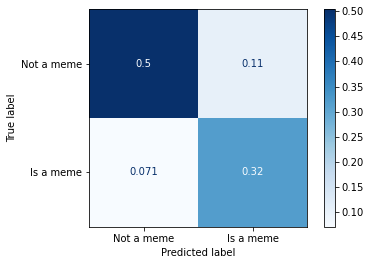

In [39]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(
    random_search_forest,
    X_test,
    y_test,
    display_labels=["Not a meme", "Is a meme"],
    cmap=plt.cm.Blues,
    normalize="all",
)

In [40]:
from sklearn.metrics import classification_report

print(classification_report(y_test, random_search_forest.predict(X_test)))

              precision    recall  f1-score   support

       False       0.88      0.83      0.85        86
        True       0.75      0.82      0.78        55

    accuracy                           0.82       141
   macro avg       0.81      0.82      0.82       141
weighted avg       0.83      0.82      0.82       141



# Text only model

In [42]:
X_train_text_only = X_train['tweet_text_only']
X_train_text_only = pd.DataFrame(X_train_text_only)

X_test_text_only = X_test['tweet_text_only']
X_test_text_only = pd.DataFrame(X_test_text_only)

In [43]:
X_train_text_only.shape

(328, 1)

In [44]:
X_train_text_only.shape

(328, 1)

In [45]:
X_train_text_only.head()

,tweet_text_only
298,tell us why you love us in 6 words or less we want to be flattered
296,we had to write our own skate-umm song so we didn’t get sued by fleetwood mac lol
6,"Where are Mickey & friends this holiday season? In the x AE collection, of course! You might not believe your eyes…"
151,a milk shake
250,best group chat ever


In [46]:
preprocessor_text_only = make_column_transformer(
    (CountVectorizer(max_features=20000), text_feature),
)

In [47]:
pipe_rf_text = make_pipeline(preprocessor_text_only, RandomForestClassifier(random_state=2, class_weight="balanced"))

In [48]:
results = {}
results["text_only random forest"] = mean_std_cross_val_scores(
    pipe_rf_text, X_train_text_only, y_train, return_train_score=True
)
pd.DataFrame(results)

,text_only random forest
fit_time,0.157 (+/- 0.006)
score_time,0.011 (+/- 0.000)
test_score,0.738 (+/- 0.064)
train_score,0.994 (+/- 0.003)


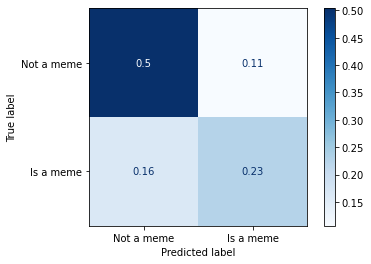

In [49]:
pipe_rf_text.fit(X_train_text_only, y_train)

plot_confusion_matrix(
    pipe_rf_text,
    X_test_text_only,
    y_test,
    display_labels=["Not a meme", "Is a meme"],
    cmap=plt.cm.Blues,
    normalize="all",
)

In [50]:
print(classification_report(y_test, pipe_rf_text.predict(X_test_text_only)))

              precision    recall  f1-score   support

       False       0.76      0.83      0.79        86
        True       0.68      0.58      0.63        55

    accuracy                           0.73       141
   macro avg       0.72      0.70      0.71       141
weighted avg       0.73      0.73      0.73       141

